# Artificial Neural Networks - Exercises 

**NOTICE:**
1. You are allowed to work in groups of up to three people but **have to document** your group's\
 members in the top cell of your notebook.
2. **Comment your code**, explain what you do (refer to the slides). It will help you understand the topics\
 and help me understand your thinking progress. Quality of comments will be graded. 
3. **Discuss** and analyze your results, **write-down your learnings**. These exercises are no programming\
 exercises it is about learning and getting a touch for these methods. Such questions might be asked in the\
 final exams. 
 4. Feel free to **experiment** with these methods. Change parameters think about improvements, write down\
 what you learned. This is not only about collecting points for the final grade, it is about understanding\
  the methods. 

In [308]:
import numpy as np 

### Exercise 1 - Training via Moore-Penrose Inverse


**Summary:** In this exercise you will use the Moore-Penrose inverse to "train" a single (linear) neuron. It will help you\
to form a more solid understanding about what training a neural network really means and which shortcomings this method\
has in a practical setting. It also acts as your first chance to get in touch with **numpy** which is one of the most useful\
libraries in any machine-learning setting. 


**Provided Code:** For this exercise I have written a function ```generate_data()``` (see cell below) that can be used to\
generate some training data. Notice that ```generate_data()``` accepts a lambda (anonymous) function to generate data. Lambdas\
can be defined like this: ```generate_data(fun=lambda x: 3*x+1)```

Some useful library functions in this exercise could be: ```numpy.ones(), numpy.column_stack(), numpy.linalg.pinv()```.\
Use ```numpy.dot()``` to compute a matrix multiplication. 



**Your Tasks in this exercise:**
1. Generate Data for any linear (affine) function and find the parameters for a single neuron using\
the Moore-Penrose inverse. 
2. Experiment with different functions and training-set sizes. 
3. Try to compute the inverse of large matrices, at what point do you reach a practical limit?
4. Why do you think this method is rarely used in practise (discuss and write-down your answer)?





In [291]:
#@title **Provided Code:** ``generate_data()`` function. 
import matplotlib.pyplot as plt 
import numpy as np 

def generate_data(fun=lambda x:3*x+1, mu=0, std=1, n=10):
    ''' Generates data for Exercise 1. Fun is a lambda (anonymous function)
    that it used to compute the target values (y) for given inputs (x), i.e.:
    y = fun(x).
    '''
    x = mu + std * np.random.randn(n)
    y = fun(x) + 0.3 * np.random.randn(n) # add some noise
    return x,y

### Exercise 2 - Neural Networks as Universal Approximators


**Summary:** In this exercise you will experiment with a neural network to understand what the Universal Approximation Theorem tells us. Remember, UAT tell us that neural networks can basically approximate any function.




**Provided Code:** For this exercise I have provided you with some python code such that will help you train a neural net. Use the ```approximate_NN()``` function to do so. You can supply custom mathematical function of your choice (the function the net tries to approximate) using lambdas such as in the call:

```python
approximate_NN(lambda x: 3*(x**2) + 6, -10, 10, epochs=50, hidden_layers=1, neurons_per_layer=32)
```

This will train the weights and biases to approximate the function $f(x):=3x^2 + 6$ within the interval $[-10;10]$ using 50 epochs for training a single layer of hidden neurons with 32 neurons each.




**Your Tasks in this exercise:**

1. Experiment and answer the following questions
    * What is the effect of changing the number of neurons vs. the number of hidden layers?
    * What is the effect of having very simple vs. more and more complex functions with regards the the required neurons/layers?
    * Does more training (more epochs) automatically mean better result?
    * Can you find a function that we can not approximate?
    * What happens outside the interval we used for training (indicated by the red dashed lines in the plots)?
    




In [18]:
#@title **Provided Code:** ``approximate_NN()`` function, and some private helpers. 

!pip install matplotlib --upgrade

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu

import math

import matplotlib.pyplot as plt
print(tf.__version__)

def target_poly(x):
    output = np.empty(len(x))
    for i in range(len(x)):
        output[i] = (1/4.0) * (x[i]+4) * (x[i] + 1) * (x[i] - 2)
    return output

def target_poly_3(x):
    output = np.empty(len(x))
    for i in range(len(x)):
        output[i] = 2 * x[i]**3 + x[i]**2 - x[i] 
    return output

# polynomial with 8 roots
def target_poly_7(x):
    output = np.empty(len(x))
    for i in range(len(x)):
        output[i] = x[i]**7 + 4*x[i]**6 - 14*x[i]**5 - 56*x[i]**4 + 49*x[i]**3 + 196*x[i]**2 - 36*x[i] - 144
    return output

# a very high dimensional polygon
def target_poly_14(x):
    output = np.empty(len(x))
    for i in range(len(x)):
        output[i] = x[i]**14 - 0.97*x[i]**13 - 27.5669*x[i]**12 + 28.596911*x[i]**11 + 291.72658501*x[i]**10 - 322.8791018467*x[i]**9 - 1482.7415839005*x[i]**8 + 1741.757256169*x[i]**7 + 3643.0791581657*x[i]**6 - 4525.2996198175*x[i]**5 - 3566.980623085*x[i]**4 + 4745.7344671655*x[i]**3 + 263.42489522071*x[i]**2 - 614.82116925297+x[i] + 66.216725787218
    return output

def target_sine(x):
    output = np.empty(len(x))
    for i in range(len(x)):
        output[i] = math.sin(x[i])
    return output


def mother_wavelet(x):
    return (np.sin(2*np.pi*x) - np.sin(np.pi * x)) / np.pi * x


def plot_target(target_func):
    x = np.linspace(-3,3, 1000) 
    plt.plot(x,target_func(x), linestyle='--', color='C1', linewidth=2)
    
def combine_neurons(neurons, weights, bias, target_func):
    x = np.arange(-3, 3, 0.01)
    y = np.zeros((len(neurons[0])))
    plt.figure(figsize=(20,8))
    fig, ax = plt.subplots()
    for index in range(len(neurons)):
        y = y + neurons[index] * weights[index]
    y = y + bias
    y2 = target_func(x)
    plt.plot(x, y, label='ReLUs', linewidth=3)
    plt.plot(x, y2, label='Real Function', linestyle='--', color='C1', linewidth=2)
    
    mse = (np.sum((y - y2)**2)) / len(y)
    
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k', linewidth=0.75)
    ax.axvline(x=0, color='k', linewidth=0.75)
    plt.title("MSE = %f" % mse)
    

def approximate_NN(target_func, min_value=-10, max_value=10, epochs=50, hidden_layers=1, neurons_per_layer=8):
    # Create a NN with a single hidden layer to learn the polynomial function
    #
    model = keras.Sequential()
    for x in range(hidden_layers):
        model.add(Dense(neurons_per_layer, input_dim=1, activation='relu', use_bias=True)) 
    model.add(Dense(1,  use_bias=True)) # 1 Neuron

    sgd = Adam(lr=0.01) # set lower learning rate
    model.compile(sgd, loss='mean_squared_error')

    # Create some data
    #
    X = np.random.uniform(min_value, max_value, (50000,1))
    Y = target_func(X)

    model.fit(X,Y, epochs=epochs, batch_size=512);

    # Plot neural network
    #
    x_test = np.arange(min_value-np.abs(min_value*0.25), max_value+np.abs(max_value*0.25), 0.01)
    y_test_nn = model.predict(x_test)
    y_real = target_func(x_test)
    
    mse = np.sum((np.ravel(y_real) - np.ravel(y_test_nn))**2)
    
    plt.figure(figsize=(8,5))
    plt.axline((min_value, 0), (min_value,10), color="r", linestyle='dashed', linewidth=0.75)
    plt.axline((max_value, 0), (max_value,10), color="r", linestyle='dashed', linewidth=0.75)
    
    plt.plot(x_test, y_test_nn, label='Approximation using NN')
    plt.plot(x_test, y_real, linestyle ='-.', label='Real Function')
    plt.legend()
    
    return model

2.10.1


Der Befehl "pip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


### Exercise 3 - Rectified Linear Units


**Summary:** In this exercise you are provided with a neuron equipped with a ReLU as activation function. You can  
 supply the neuron parameters manually (the weight and bias term) as ```neuron(3, 2)``` will compute and plot  
 all the output values generated by the neuron for all input values in an interval of $[-3;3]$.

 **Hint:** You can use the semi-colon in the call ```neuron(3, 2);``` to suppress the output. 

**Provided Code:** In the cell below you find the implementation of the ```neuron()``` function. 


**Your Tasks in this exercise:**

1. Experiment and answer the following questions
    * What is the effect of changing the weight?
    * What is the effect of changing the bias?




In [8]:
#@title **Provided Code:** ``neuron()`` function. 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

def neuron(w, b, plot=True):
    x = np.arange(-3, 3, 0.01)
    y = tf.keras.activations.relu(x * w + b)
    if plot:
        fig, ax = plt.subplots()
        plt.ylim((-10, 10)) 
        ax.grid(True, which='both')
        plt.plot(x, y)
    return y

### Exercise 4:


**Summary:** A mathematical function is linear *iff* $f(x)+f(y) = f(x+y)$ and $\lambda f(x) = f(\lambda x)$.

**Provided Code:** No code.


**Your Tasks in this exercise:**

1. Show that ReLU is not a linear function. 



### Exercise 5:


**Summary:** You saw that we can combine neurons to a neural network. Try to manually find the weights for approximating the ```target_poly_3``` function.  Use the ```combine_neurons``` function to combine multiple neurons. 

```python 
def combine_neurons(neurons, weights, bias, target_func):
    """ Parameters:
    neurons - a list of neurons such sa created by the neuron() function
    weights - a list of weights used by the output layer neuron
    bias - a single bias value used by the output layer neuron
    target_func - a function to plot as reference for approximation
    """  
```

**Provided Code:** In the cell below you find the implementation of the ```combine_neurons()``` function. 


**Your Tasks in this exercise:**

1. Experiment with parameters for a neural network to approximate the ```target_poly_3``` function (*You can do this via trial and error / elaborate guessing, no calculations are necessary*).
2. Try to find the parameters of a neural network to approximate the ```target_sine``` function (*this might be difficult*).
3. Use the call to ```model = approximate_NN(...)``` to let tensorflow find the weights and biases for approximating the ```target_sine``` function. Have a look at ```model.layers[0].weights``` and ```model.layers[1].weights``` to help you find appropriate parameters for this problem. 


In [21]:
#@title **Provided Code:** ``combine_neurons()`` function. 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

def combine_neurons(neurons, weights, bias, target_func):
    x = np.arange(-3, 3, 0.01)
    y = np.zeros((len(neurons[0])))
    plt.figure(figsize=(20,8))
    fig, ax = plt.subplots()
    for index in range(len(neurons)):
        y = y + neurons[index] * weights[index]
    y = y + bias
    y2 = target_func(x)
    plt.plot(x, y, label='ReLUs', linewidth=3)
    plt.plot(x, y2, label='Real Function', linestyle='--', color='C1', linewidth=2)
    
    mse = (np.sum((y - y2)**2)) / len(y)
    
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k', linewidth=0.75)
    ax.axvline(x=0, color='k', linewidth=0.75)
    plt.title("MSE = %f" % mse)

<Figure size 2000x800 with 0 Axes>

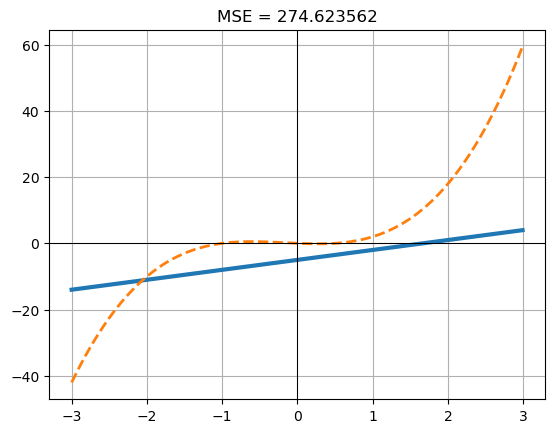

In [20]:
# Combine two neurons 
#
r1 = neuron(3,0, False)
r2 = neuron(-3,0, False)
# r1 is weighted by 1 and -1 with a bias of -5 in the output layer neuron
#
combine_neurons([r1, r2], [1, -1], -5, target_poly_3)